# BEEF: Bayesian Error Estimate Functionals

Matthew Evans

Going to consider PBE-like GGA-DFT exchange functionals: just a local functional of density $n$ and $s$, where

$$ s = \frac{|\nabla n|}{2k_F n}. $$

Each of PW-91, PBE, revPBE and RPBE differ only by $F_x(s)$:

$$ E_x[n] = \int \mathrm{d}\mathbf{r}\, n(\mathbf{r}) \varepsilon_x^\text{LDA}(n(\mathbf{r}))F_x(s).$$

e.g. PBE $F_x(s)$:

$$ F^\text{PBE}_x(s) = 1 + \kappa - \kappa\left({1 + \frac{\mu s^2}{\kappa}}\right)^{-1}, $$

with $\kappa = 0.804$ and $\mu = 0.219$.


Model:

$$ F_x(s) = \sum_{i=1}^{N_p} \theta_i \left(\frac{s}{1+s}\right)^{2i-2}. $$

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

In [51]:
s = np.linspace(0, 3, 100)
Fx_GGA = lambda κ, µ: 1 + κ - κ / (1 + (µ * s**2 / κ))
Fx_GGA_exp = lambda κ, µ: 1 + κ * (1 - np.exp(-µ * s**2 / κ))
Fx_LDA = 1 + 0*s

Fx_PBE = Fx_GGA(0.804, 0.219)
Fx_RPBE = Fx_GGA(1.245, 0.219)
Fx_revPBE = Fx_GGA_exp(0.804, 0.219)

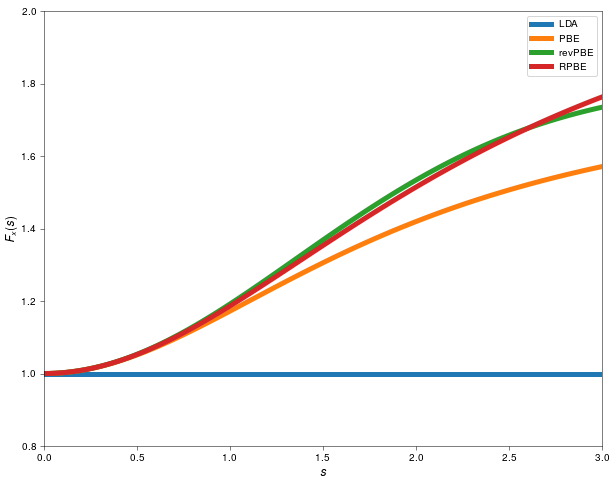

In [52]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_xlabel('$s$')
ax.set_ylabel('$F_x(s)$')
ax.plot(s, len(s)*[1], label='LDA', lw=5)
ax.plot(s, Fx_PBE, label='PBE', lw=5)
ax.plot(s, Fx_revPBE, label='revPBE', lw=5)
ax.plot(s, Fx_RPBE, label='RPBE', lw=5)
ax.set_ylim(0.8, 2)
ax.set_xlim(0, 3)
ax.legend()

Fitting finds $s=0$ naturally.

For $s>1.5$, fitting ends up somewhere between PBE and RPBE.

## Fitting procedure:

1. Calculate electron density self-consistently using PBE.
2. Evaluate exchange-correlation energy for ensemble of functionals
$$ E(\theta) = E_0 + \sum_{i=1}^3 \Delta E_i \theta_i, $$
*non-self-consistently* on the PBE density.
3. Adjust $\theta$ to minimise cost function (least squares error).

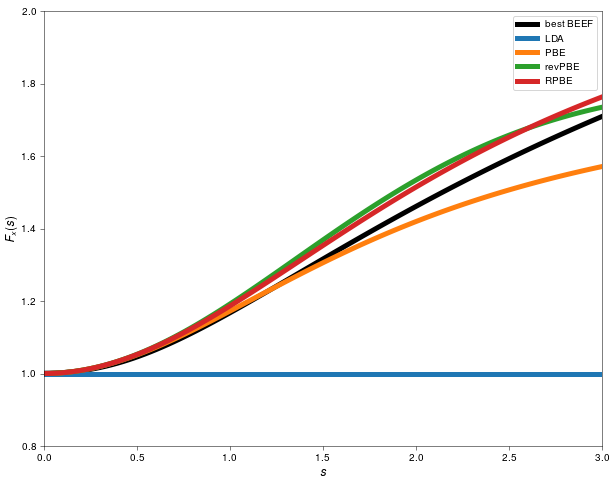

In [150]:
def Fx_BEEF(s, thetas=[1.0008, 0.1926, 1.8962]):
    Fx = np.zeros_like(s)
    for i in range(3):
        Fx += thetas[i] * (s/(1+s))**(2*(i+1)-2)
    return Fx


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_xlabel('$s$')
ax.set_ylabel('$F_x(s)$')

ax.plot(s, Fx_BEEF(s), c='k', ls='-', lw=5, label='best BEEF')
ax.plot(s, len(s)*[1], label='LDA', lw=5)
ax.plot(s, Fx_PBE, label='PBE', lw=5)
ax.plot(s, Fx_revPBE, label='revPBE', lw=5)
ax.plot(s, Fx_RPBE, label='RPBE', lw=5)
ax.set_ylim(0.8, 2)
ax.set_xlim(0, 3)
ax.legend()

> "We would like to stress that the main point of this Letter is not to derive an improved functional..."

> "and we do not expect to obtain a large overall improvement within this simple GGA framework. But as we shall see in the following the ensemble construction allows for realistic evaluation of the error bars on calculated quantities."

We would expect the probability of reaching parameters $\theta$ given our model $M$ and the database $D$ to be:

$$ P(\theta|MD) \sim \exp{\left(-\frac{C(\theta)}{T}), $$

where $T$ is some effective temperature and $C(\theta)$ is our least squares cost function wrt. experimental database.

Turns out that the least square cost function is very close to harmonic in the relevant region of parameter space, so we can expand this:
    
$$ \frac{C(\theta)}{T} = \text{const.} + \frac{1}{2}\Delta \theta^T A \Delta \theta, $$

where $A$ is a symmetry matrix and $U$ being the matrix that diagonalises $A$ such that $AU = U\Lambda$. Leading to

$$ \theta = \theta_\text{bf} = U \Lambda^{-1/2} \alpha, $$

for vector $\alpha$ with elements $\alpha_i$ such that $\mathcal{P}(\alpha_i) \sim \exp{(-\alpha_i^2/2)}$.

Thus, we can generate a properly distributed ensemble of enhancement factors around the best fit. Can therefore define error on any arbitrary observable $O$ in the standard way:

$$ \sigma_\text{BEE}(O) = \sqrt{\frac{1}{N} \sum_{\mu=1}^N (O(\theta^\mu) - \theta_\text{bf})^2}. $$

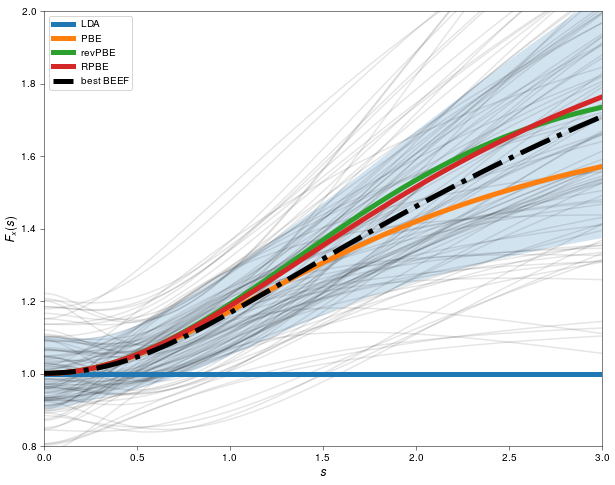

In [169]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_xlabel('$s$')
ax.set_ylabel('$F_x(s)$')

U_over_sqrtlambda = np.matrix([[0.066, 0.055, -0.034], [-0.812, 0.206, 0.007], [1.996, 0.082, 0.004]])
theta_bf = [1.0008, 0.1926, 1.8962]
error = np.zeros_like(s)

N = 100

for _ in range(N):
    alpha = np.random.normal(size=(3))
    thetas = theta_bf + np.asarray((U_over_sqrtlambda @ alpha))[0]
    ax.plot(s, Fx_BEEF(s, thetas=thetas), alpha=10/N, c='k')
    error += (Fx_BEEF(s, thetas=thetas) - F_x_BEEF(s, thetas=theta_bf))**2
    
error = np.sqrt(error / N)
            
ax.plot(s, len(s)*[1], label='LDA', lw=5)
ax.plot(s, Fx_PBE, label='PBE', lw=5)
ax.plot(s, Fx_revPBE, label='revPBE', lw=5)
ax.plot(s, Fx_RPBE, label='RPBE', lw=5)
ax.plot(s, Fx_BEEF(s), c='k', ls='-.', lw=5, label='best BEEF')
ax.fill_between(s, Fx_BEEF(s)+error, Fx_BEEF(s)-error, alpha=0.2)
ax.set_ylim(0.8, 2)
ax.set_xlim(0, 3)
ax.legend()

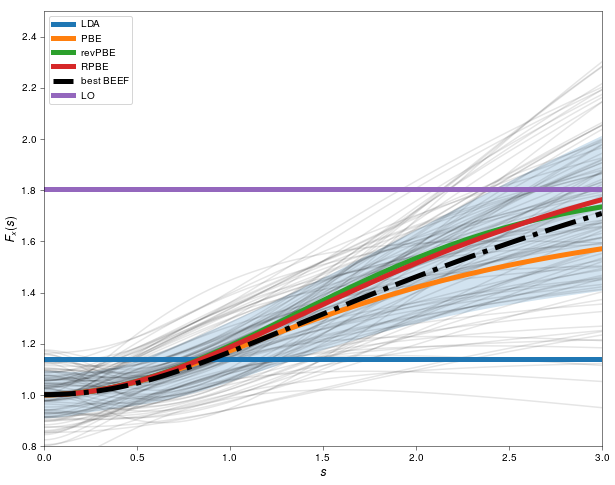

In [183]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_xlabel('$s$')
ax.set_ylabel('$F_x(s)$')

U_over_sqrtlambda = np.matrix([[0.066, 0.055, -0.034], [-0.812, 0.206, 0.007], [1.996, 0.082, 0.004]])
theta_bf = [1.0008, 0.1926, 1.8962]
error = np.zeros_like(s)

N = 100

for _ in range(N):
    alpha = np.random.normal(size=(3))
    thetas = theta_bf + np.asarray((U_over_sqrtlambda @ alpha))[0]
    ax.plot(s, Fx_BEEF(s, thetas=thetas), alpha=10/N, c='k')
    error += (Fx_BEEF(s, thetas=thetas) - F_x_BEEF(s, thetas=theta_bf))**2
    
error = np.sqrt(error / N)
            
ax.plot(s, len(s)*[1.14], label='LDA', lw=5)

ax.plot(s, Fx_PBE, label='PBE', lw=5)
ax.plot(s, Fx_revPBE, label='revPBE', lw=5)
ax.plot(s, Fx_RPBE, label='RPBE', lw=5)
ax.plot(s, Fx_BEEF(s), c='k', ls='-.', lw=5, label='best BEEF')
ax.fill_between(s, Fx_BEEF(s)+error, Fx_BEEF(s)-error, alpha=0.2)
ax.plot(s, len(s)*[1.804], label='LO', lw=5)
ax.set_ylim(0.8, 2.5)
ax.set_xlim(0, 3)
ax.legend()

As you can see, the spread of the ensemble is much greater than the difference between the best fit and the well-known functionals, can alternatively calculate errors wrt. PBE result.

To compare across different observables, just compute $(O_\text{bf}-O_\text{exp})/\sigma_\text{BEE}(O)$.

<center><img src="https://journals.aps.org/prl/article/10.1103/PhysRevLett.95.216401/figures/2/medium" align="center"/></center>

Reasonable?

Things to think about:
    
    - LDA limit of F_x
    - LO limit of F_x
    - Regularisation, fitting procedure from multiple datasets
    - List data that was actually fitted to (c.f. PBE)
    - THEN prettifying notebook and plots